### Discretization

One of the benchmark algorithms - SimOOS from "Data-Driven Online Recommender Systems With Costly Information Acquisition" works by enumerating all possible states. For it to work correctly each dimension of context vectors should have only a finite number of values in the whole dataset.

In this notebook I want to see what happens if I discretize the context vectors, that is, I fix the number of values and round the values of context vectors to the closes possible value.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import algorithms
import costs
import evaluation
import dataset

In [22]:
%%time
import gc

with open("dataset/R6/subsample/data_04.pickle", "rb") as f:
    gc.disable()
    data = pickle.load(f)
    gc.enable()

CPU times: user 4.03 s, sys: 3.53 s, total: 7.56 s
Wall time: 33.3 s


In [4]:
X = np.stack(
 [
     ev.user_features for ev in data.events
 ]
)


In [5]:
column = 4
np.unique(X[:, column]).shape

(261871,)

In [6]:
def discretize(array, num_bins):
    x_min = min(array)
    x_max = max(array)
    bins = np.linspace(x_min, x_max, num_bins+1)
    new_array = array.copy()
    for i in range(len(array)):
        x = array[i]
        if x >= x_max:
            new_x = x_max
        elif x <= x_min:
            new_x = x_min
        else:
            new_x = bins[np.digitize(x, bins)]
        new_array[i] = new_x
    return new_array

In [7]:
discretize([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.8, 0.7, 0.6, 1], 4)

[0, 0.25, 0.25, 0.5, 0.5, 0.75, 1.0, 1.0, 0.75, 0.75, 1]

In [8]:
X.shape

(3243176, 6)

In [10]:
X[:5, :]

array([[1.10000e-04, 0.00000e+00, 9.98651e-01, 8.01000e-04, 4.38000e-04,
        1.00000e+00],
       [2.02760e-02, 1.23500e-03, 1.74800e-03, 3.47500e-03, 9.73265e-01,
        1.00000e+00],
       [1.53300e-03, 3.00000e-06, 6.19900e-03, 4.67900e-03, 9.87586e-01,
        1.00000e+00],
       [2.67000e-04, 4.00000e-06, 2.27000e-04, 6.16000e-04, 9.98886e-01,
        1.00000e+00],
       [3.01460e-02, 2.24000e-04, 6.33680e-02, 3.55110e-02, 8.70751e-01,
        1.00000e+00]])

In [14]:
X_disc = np.ones(X.shape)

In [49]:
NUM_BINS = 1000
for column in range(6):
    X_disc[:, column] = discretize(X[:, column], NUM_BINS)

In [50]:
X_disc

array([[9.77238000e-04, 0.00000000e+00, 9.98993007e-01, 9.98013000e-04,
        1.00000000e-03, 1.00000000e+00],
       [2.05219980e-02, 1.99988600e-03, 1.99998600e-03, 3.99205200e-03,
        9.74000000e-01, 1.00000000e+00],
       [1.95447600e-03, 9.99943000e-04, 6.99995100e-03, 4.99006500e-03,
        9.88000000e-01, 1.00000000e+00],
       ...,
       [2.38446072e-01, 2.59985180e-01, 1.69998810e-02, 4.86032331e-01,
        1.00000000e-03, 1.00000000e+00],
       [2.93171400e-03, 1.99988600e-03, 9.99993000e-04, 5.98807800e-03,
        9.91000000e-01, 1.00000000e+00],
       [9.77238000e-04, 9.99943000e-04, 9.99993000e-04, 9.98013000e-04,
        1.00000000e+00, 1.00000000e+00]])

In [30]:
NUM_OF_TRIALS = 100000

In [51]:
for event, x in zip(data.events,X_disc):
    event.user_features = x

In [45]:
p_random = algorithms.RandomPolicy()
ctr_random = evaluation.evaluate(p_random, data, stop_after=NUM_OF_TRIALS)

Random policy with ZeroCosts
Average reward: 0.033
Execution time: 9.3s


In [46]:
ucb_alg = algorithms.UCB1(
        n_arms=data.n_arms,
        alpha=0.01,
    )
ctr_ucb = evaluation.evaluate(ucb_alg, data, stop_after=NUM_OF_TRIALS)

UCB1 (α=0.01) with ZeroCosts
Average reward: 0.0492
Execution time: 18.2s


In [52]:
linucb = algorithms.LinUCB(
    context_dimension=len(data.events[0].user_features),
    n_arms=data.n_arms,
    alpha=0.3,
)
ctr_linucb = evaluation.evaluate(linucb, data, stop_after=NUM_OF_TRIALS)

LinUCB (alpha=0.3) with ZeroCosts
Average reward: 0.049
Execution time: 41.6s


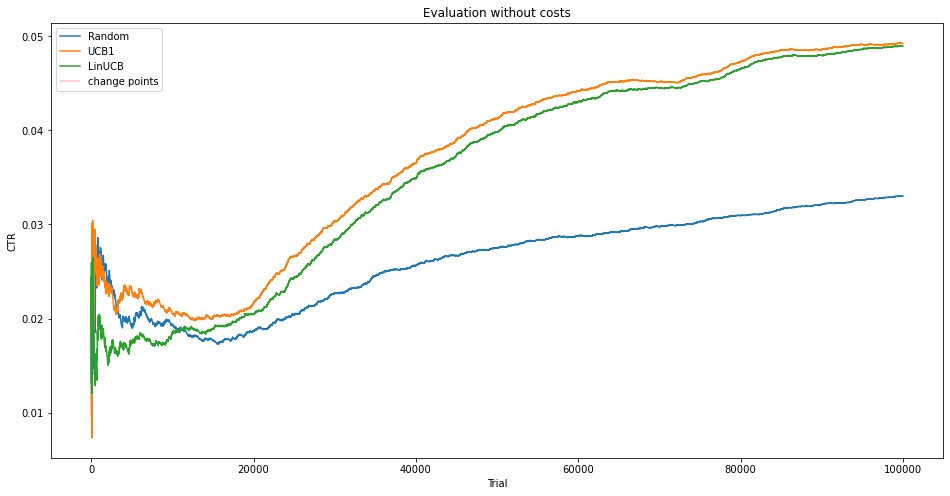

In [53]:
plot_ctrs(
    {
        'Random': ctr_random,
        'UCB1': ctr_ucb,
        'LinUCB': ctr_linucb,
    },
)


In [36]:
raise ValueError("STOP")

ValueError: STOP

### For comparison running on original data

In [31]:
p_random = algorithms.RandomPolicy()
ctr_random = evaluation.evaluate(p_random, data, stop_after=NUM_OF_TRIALS)

Random policy with ZeroCosts
Average reward: 0.0319
Execution time: 8.8s


In [32]:
ucb_alg = algorithms.UCB1(
        n_arms=data.n_arms,
        alpha=0.01,
    )
ctr_ucb = evaluation.evaluate(ucb_alg, data, stop_after=NUM_OF_TRIALS)

UCB1 (α=0.01) with ZeroCosts
Average reward: 0.0492
Execution time: 17.3s


In [33]:
linucb = algorithms.LinUCB(
    context_dimension=len(data.events[0].user_features),
    n_arms=data.n_arms,
    alpha=0.3,
)
ctr_linucb = evaluation.evaluate(linucb, data, stop_after=NUM_OF_TRIALS)

LinUCB (alpha=0.3) with ZeroCosts
Average reward: 0.0575
Execution time: 44.1s


In [34]:
def plot_ctrs(ctr_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
    
    N = 40
    
    max_vline=0
    
    for label, ctr in ctr_dict.items():
        ax.plot(ctr[N:], label=label)
        max_vline=max(max_vline, max(ctr[N:]))
    ax.set_xlabel('Trial')
    ax.set_ylabel('CTR')
    ax.set_title('Evaluation without costs')
    
    ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

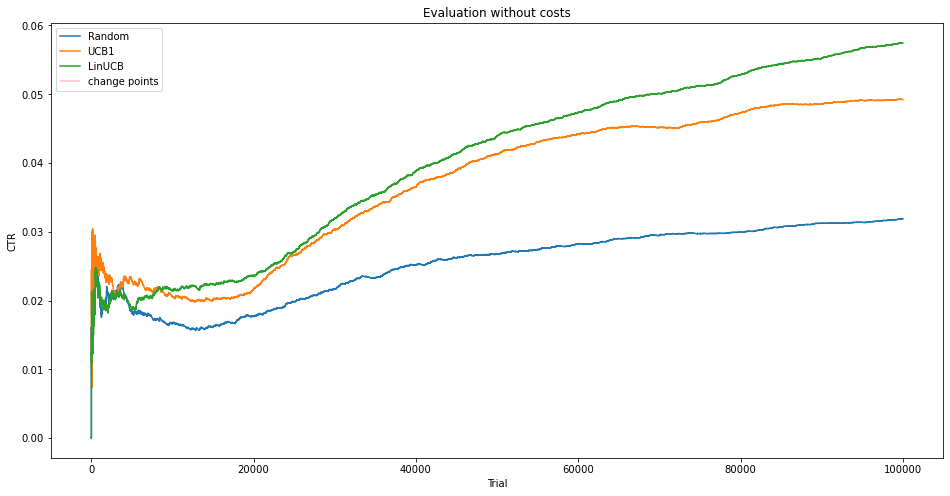

In [35]:
plot_ctrs(
    {
        'Random': ctr_random,
        'UCB1': ctr_ucb,
        'LinUCB': ctr_linucb,
    },
)
